***
LIBRARIES: most required ones
***

In [78]:
%pip install torch torchvision torchsummary

Note: you may need to restart the kernel to use updated packages.


In [79]:
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt # plot


import torch # pytorch
import torch.nn as nn # neural network
import torch.optim as optim # optimizer
from torchsummary import summary # model summary (architecture)
from torch.utils.data import DataLoader, random_split # dataloader, dataset split
from torchvision import transforms,datasets # image processing, datasets
import torchvision.models as models # pretrained models

DATA_PATH = './dataset'

***
DATA LOADING
***

In [80]:
#Transformation for image
transform_ori = transforms.Compose([transforms.RandomResizedCrop(128),   #create 64x64 image
                                    transforms.RandomHorizontalFlip(),    #flipping the image horizontally
                                    transforms.ToTensor(),                 #convert the image to a Tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image
                                    

In [81]:
dataset = datasets.ImageFolder(root = DATA_PATH, transform=transform_ori)
data_size = len(dataset)

In [82]:
test_size = int(data_size * 0.25)
train_size = int(data_size * 0.75)
generator = torch.Generator().manual_seed(42)
training, testing = random_split(dataset, [train_size, test_size], generator=generator)

In [83]:
#Make the dataset iterable
batch_size = 32
train_load = DataLoader(dataset = training, 
                                         batch_size = batch_size,
                                         shuffle = True) 

test_load = torch.utils.data.DataLoader(dataset = testing, 
                                         batch_size = batch_size,
                                         shuffle = False)

***
ARCHITECTURE DEFINING
***

In [115]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lastcnn = nn.Linear(in_features=64 * 64 * 64, out_features=5)   
        self.relu=nn.ReLU()     

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x) 
        # x = torch.flatten(x)  
        x = x.view(x.size(0), -1)    
        x = self.lastcnn(x)   
        x=self.relu(x)     
        return torch.log_softmax(x, dim=1)
    
    # def conv_block(self, c_in, c_out, dropout, **kwargs):
    #     seq_block = nn.Sequential(
    #         nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
    #         nn.BatchNorm2d(num_features=c_out),
    #         nn.ReLU(),
    #         nn.Dropout2d(p=dropout)
    #     )        
    #     return seq_block
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=5).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lastcnn): Linear(in_features=262144, out_features=5, bias=True)
  (relu): ReLU()
)


***
OBJECTS: CRITERION, OPTIMIZER, SCHEDULER(maybe)
***

In [116]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

***
TRAINING AND VALIDATION: Validation not neccessary but recommended
***

In [117]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)        
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)    
    acc = torch.round(acc * 100)    
    return acc

In [118]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [119]:
# print("Begin training.")
# for e in tqdm(range(1,2)):    # TRAINING    train_epoch_loss = 0
#     train_epoch_loss =0
#     train_epoch_acc = 0    
    
#     model.train()
#     for X_train_batch, y_train_batch in train_load:
#         X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)        
#         optimizer.zero_grad()        
#         y_train_pred = model(X_train_batch).squeeze()        
#         train_loss = criterion(y_train_pred, y_train_batch)
#         train_acc = multi_acc(y_train_pred, y_train_batch)        
#         train_loss.backward()
#         optimizer.step()        
#         train_epoch_loss += train_loss.item()
#         train_epoch_acc += train_acc.item()
#     # # VALIDATION
#     # with torch.no_grad():
#     #     model.eval()
#     #     val_epoch_loss = 0
#     #     val_epoch_acc = 0
#     #     for X_val_batch, y_val_batch in val_loader:
#     #         X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)            
#     #         y_val_pred = model(X_val_batch).squeeze()            
#     #         y_val_pred = torch.unsqueeze(y_val_pred, 0)            
#     #         val_loss = criterion(y_val_pred, y_val_batch)
#     #         val_acc = multi_acc(y_val_pred, y_val_batch)            
#     #         val_epoch_loss += train_loss.item()
#     #         val_epoch_acc += train_acc.item()    
#     #         loss_stats['train'].append(train_epoch_loss/len(train_loader))
#     # loss_stats['val'].append(val_epoch_loss/len(val_loader))
#     accuracy_stats['train'].append(train_epoch_acc/len(train_load))
#     # accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
#     print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_load):.5f} | Train Acc: {train_epoch_acc/len(train_load):.3f}')

In [120]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [121]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [122]:
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 1
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_load, optimizer, epoch)
        test_loss = test(model, device, test_load)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.522736
	Training batch 2 Loss: 227.914352
	Training batch 3 Loss: 40.661289
	Training batch 4 Loss: 87.397316
	Training batch 5 Loss: 15.382833
	Training batch 6 Loss: 14.122752
	Training batch 7 Loss: 58.850834
	Training batch 8 Loss: 28.779690
	Training batch 9 Loss: 1.190001
	Training batch 10 Loss: 1.059446
	Training batch 11 Loss: 15.690999
	Training batch 12 Loss: 27.891432
	Training batch 13 Loss: 12.094986
	Training batch 14 Loss: 0.502950
	Training batch 15 Loss: 0.502977
	Training batch 16 Loss: 2.027539
	Training batch 17 Loss: 0.653834
	Training batch 18 Loss: 0.653834
	Training batch 19 Loss: 0.502949
	Training batch 20 Loss: 0.603539
	Training batch 21 Loss: 1.124825
	Training batch 22 Loss: 0.603539
	Training batch 23 Loss: 0.855014
	Training batch 24 Loss: 0.502949
	Training batch 25 Loss: 0.402359
	Training batch 26 Loss: 0.653834
	Training batch 27 Loss: 0.452654
	Training batch 28 Loss: 0.603539
	Training batch 29 Lo

***
PLOTTING: Loss & Accuracy
***

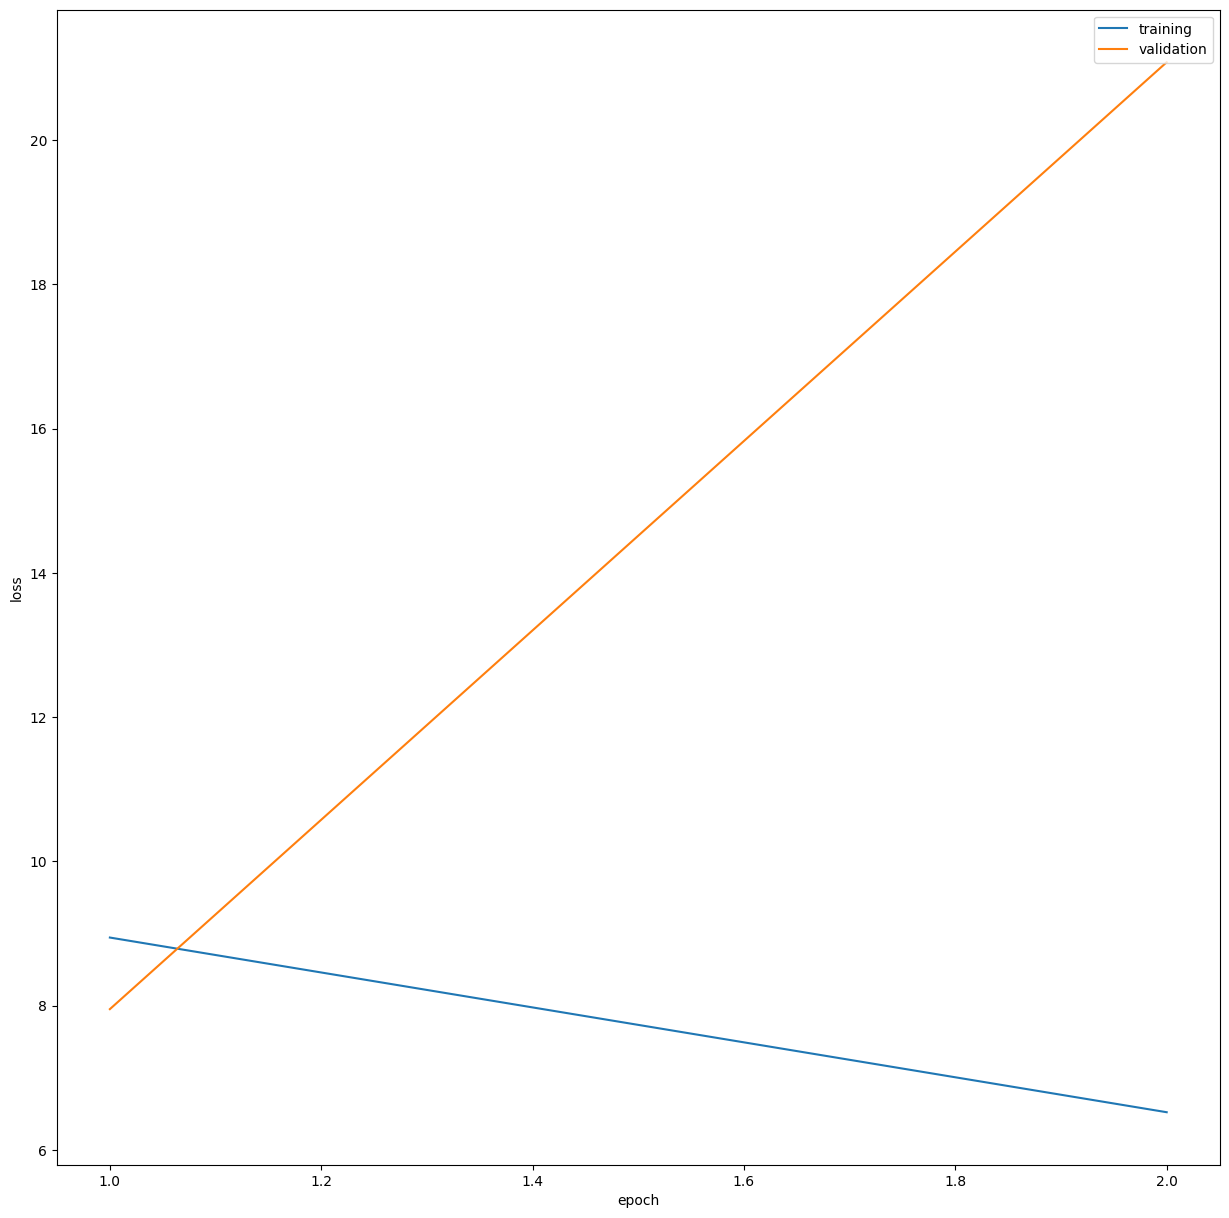

In [113]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

***
SAVING
***

In [114]:
width,height = 128,128
x = torch.Tensor(1, 3, width, height)
with torch.no_grad():
    traced_cell = torch.jit.trace(model, (x))
model_name = "./models/C_team2.pt" # CHANGE THIS TO YOUR OWN PATH (most improtatnt step)
torch.jit.save(traced_cell, model_name)


# torch.save () this is not allowed because it requires class definition before loading for the 
# model evaluation